## Overview

1. [Single Cell Model](#single-cell-model)
2. [Network Simulations](#network-simulations)
3. [Fit of the Transfer Function (to do)](#fit-of-the-transfer-function)
4. [Mean Field Model](#mean-field-model)
5. [Whole Brain Model](#whole-brain-model)
6. [PCI](#pci)
7. [BOLD and FC](#bold-and-fc)
8. [Dynamical Analysis (to do)](#dynamical-analysis)

In [315]:
%matplotlib widget

In [2]:
%precision 2
%load_ext autoreload
%autoreload 2

In [3]:
%run setup.py

Everything is now installed. You can proceed. 


<a class="anchor" id="single-cell-model"></a>
### Single Cell Model

In this implementations we select the **AdEx model**, described as following: 


$c_{m}  \frac{dv}{dt}  =  g_L(E_L-v)+ g_L\Delta e^{\frac{v-v_{thr}}{\Delta }} -W + I_{syn}$  

$\frac{dW}{dt}  =  -\frac{1}{\tau_w} (a(v-E_L) - W) + b \sum_{t_{sp}}\delta(t-t_{sp})$

These equations are used in the `eqs` variable of the Brian implementation.

You can select a different model and adjust the `eqs` and the relevant parameters of the model accordingly.

In [103]:
#These are the arguments and default values - to try different parameters refer to the script
%run single_cell_sim.py --help

usage: single_cell_sim.py [-h] [--b_e B_E] [--iext IEXT] [--tau_e TAU_E]
                          [--tau_i TAU_I] [--time TIME]

optional arguments:
  -h, --help     show this help message and exit
  --b_e B_E      adaptation (pA) (default: 60)
  --iext IEXT    input current (nA) (default: 0.3)
  --tau_e TAU_E  excitatory synaptic decay (ms) (default: 5.0)
  --tau_i TAU_I  inhibitory synaptic decay (ms) (default: 5.0)
  --time TIME    Total Time of simulation (ms) (default: 200)


Simulation of a single neuron. In this case we simulate the activity of a regular spiking cell, with adaptation.

8.0


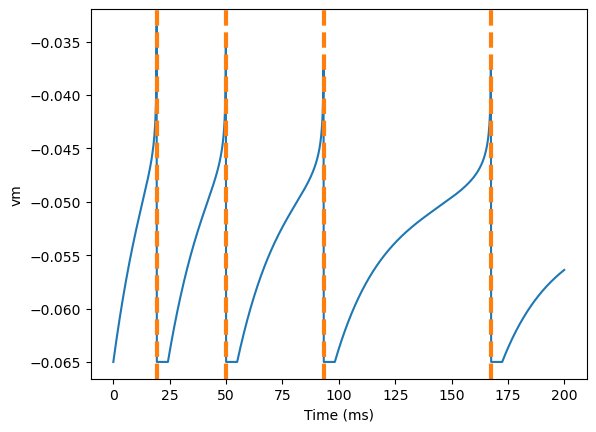

In [8]:
%run single_cell_sim.py --type='RS'

<a id="network-simulations"></a>
### Network Simulations

In [117]:
#These are the arguments and default values - for more changes go to the script
%run adex_simulation_network.py --help

usage: adex_simulation_network.py [-h] [--cells CELLS] [--b_e B_E]
                                  [--tau_e TAU_E] [--tau_i TAU_I]
                                  [--use_new USE_NEW] [--iext IEXT]
                                  [--input INPUT] [--time TIME]
                                  [--save_path SAVE_PATH]

options:
  -h, --help            show this help message and exit
  --cells CELLS         cell types of the populations (default: FS-RS)
  --b_e B_E             adaptation (pA) (default: 0.0)
  --tau_e TAU_E         excitatory synaptic decay (ms) (default: 5.0)
  --tau_i TAU_I         inhibitory synaptic decay (ms) (default: 5.0)
  --use_new USE_NEW     use input parameters - if False: will use the ones in
                        params file (default: False)
  --iext IEXT           external input (Hz) (default: 0.5)
  --input INPUT         Stable input amplitude (Hz) (default: 0)
  --time TIME           Total Time of simulation (ms) (default: 1000)
  --save_path SAVE_P

cell parameters --NOT-- in SI units
--##Start simulation##--
--##End simulation##--


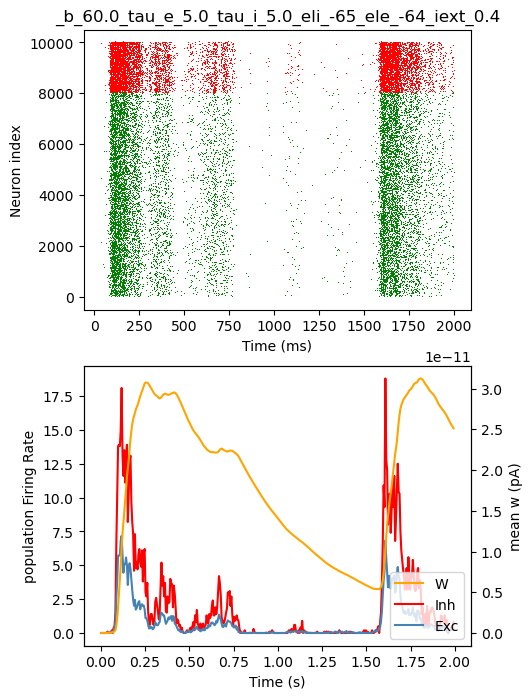

 done


In [122]:
%run adex_simulation_network.py --time 2000 --b_e 60 --use_new True --iext 0.4

In [123]:
import subprocess

# Define a list of input values
input_values = [0.5, 2.5, 5, 7.5, 10, 15, 20, 25]

# Loop through the input values and run the script with each value
for input_value in input_values:
    command = f"python adex_simulation_network.py --input {input_value} --time 2000 --save_path './net_compar/' "
    subprocess.run(command, shell=True)


cell parameters --NOT-- in SI units
Input = 1.0
--##Start simulation##--
--##End simulation##--


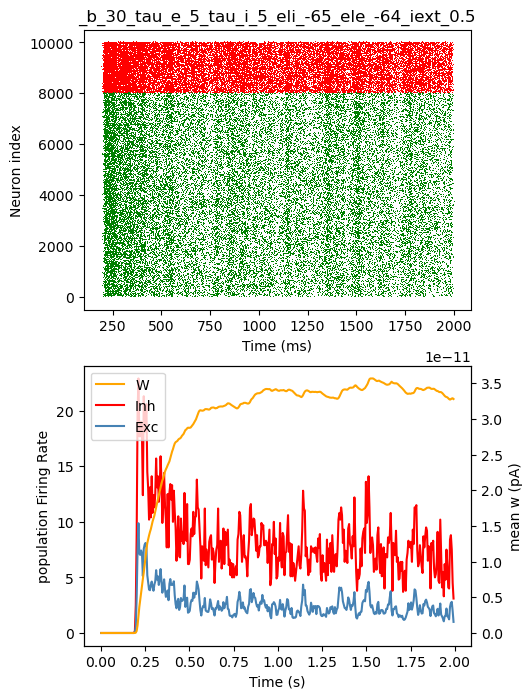

 done


In [119]:
%run adex_simulation_network.py --input 1 --time 2000

In [33]:
params_file = './data/params_range_trial.npy'
feSim, fiSim, params = np.load(params_file,allow_pickle=True) 

In [34]:
params

{'V_m': -60,
 'V_r': -65,
 'Cm': 200,
 'Gl': 10,
 'tau_w': 500,
 'V_th': -50,
 'V_cut': -30,
 'a_e': 0,
 'b_e': 30,
 'delta_e': 2,
 'EL_e': -64,
 'a_i': 0,
 'b_i': 0,
 'delta_i': 0.50,
 'EL_i': -65,
 'tau_e': 5,
 'tau_i': 5,
 'E_e': 0,
 'E_i': -80,
 'Q_i': 5.00,
 'Q_e': 1.50,
 'p_con': 0.05,
 'gei': 0.20,
 'Ntot': 10000}

In [5]:
# Now making the numerical simulations at various levels of both excitatory and inhibitory inputs
%run Tf_calc/tf_simulation.py --cells FS-RS --range_inh 0.1,30,50 --range_exc 0.1,30,50 --time 4000 
# paper's value -> 5-10 minutes sim

rate exc = 0.1
rate inh = 0.1


WARNING    'Cm' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Cm' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


rate inh = 0.710204081632653


WARNING    'Cm' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Cm' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


rate inh = 1.3204081632653062
rate inh = 1.9306122448979592
rate inh = 2.5408163265306123
rate inh = 3.1510204081632653
rate inh = 3.7612244897959184
rate inh = 4.371428571428571
rate inh = 4.981632653061224
rate inh = 5.591836734693877
rate inh = 6.20204081632653
rate inh = 6.812244897959183
rate inh = 7.422448979591836
rate inh = 8.03265306122449
rate inh = 8.642857142857142
rate inh = 9.253061224489796
rate inh = 9.863265306122448
rate inh = 10.4734693877551
rate inh = 11.083673469387755
rate inh = 11.693877551020408
rate inh = 12.30408163265306
rate inh = 12.914285714285713
rate inh = 13.524489795918367
rate inh = 14.13469387755102
rate inh = 14.744897959183673
rate inh = 15.355102040816325
rate inh = 15.965306122448979
rate inh = 16.575510204081635
rate inh = 17.185714285714287
rate inh = 17.79591836734694
rate inh = 18.406122448979595
rate inh = 19.016326530612247
rate inh = 19.6265306122449
rate inh = 20.23673469387755
rate inh = 20.846938775510203
rate inh = 21.45714285714286
r

In [24]:
%run Tf_calc/theoretical_tools --help

usage: theoretical_tools.py [-h] [-f FILE] [--cell CELL]
                            [--params_file PARAMS_FILE] [--With_Square]

 
     '=================================================='
     '=====> FIT of the transfer function =============='
     '=== and theoretical objects for the TF relation =='
     '=================================================='
     

options:
  -h, --help            show this help message and exit
  -f FILE, --FILE FILE  file name of numerical TF data
  --cell CELL           type of cell
  --params_file PARAMS_FILE
                        parameter file
  --With_Square         Add the square terms in the TF formula
                         then we have 7 parameters


In [3]:
file = './data/ExpTF_inh_50x50_trial.npy'
cell = 'FS'
param_file = './data/params_range_trial.npy'

feSim, fiSim, params = np.load(param_file,allow_pickle=True) 
params

{'V_m': -60,
 'V_r': -65,
 'Cm': 200,
 'Gl': 10,
 'tau_w': 500,
 'V_th': -50,
 'V_cut': -30,
 'a_e': 0,
 'b_e': 30,
 'delta_e': 2,
 'EL_e': -64,
 'a_i': 0,
 'b_i': 0,
 'delta_i': 0.50,
 'EL_i': -65,
 'tau_e': 5,
 'tau_i': 5,
 'E_e': 0,
 'E_i': -80,
 'Q_i': 5.00,
 'Q_e': 1.50,
 'p_con': 0.05,
 'gei': 0.20,
 'Ntot': 10000}

In [53]:
file = './data/ExpTF_inh_50x50_trial.npy'
cell = 'FS'
param_file = './data/params_range_trial.npy'
adapt_file= "./data/ExpTF_Adapt_inh_50x50_trial.npy"

In [389]:
from Tf_calc.theoretical_tools import  make_fit_from_data_fede
cell = 'FS'
pts = 50
save_name = 'trial'
# cell_sm = 'inh'
file = f'./data/ExpTF_{pts}x{pts}_{save_name}_{cell}.npy'

adapt_file= f"./data/{pts}x{pts}_{save_name}_{cell}_adapt.npy"

param_file = f'./data/{pts}x{pts}_{save_name}_{cell}_params.npy'
adapt_file=f"./data/{pts}x{pts}_{save_name}_{cell}_adapt.npy"

P = make_fit_from_data_fede(file, cell, param_file, adapt_file,range_exc=None, range_inh=None, 
window=20, loop_n=1, vthr_tol=1e-19,tf_tol=1e-20, w_prec=False)
# make_fit_from_data_2(file, cell, param_file, with_square_terms=True)

WARNING    c:\Users\maria\Documents\tvb\Paper_github\Tf_calc\theoretical_tools.py:785: OptimizeWarning:

Unknown solver options: seed

 [py.warnings]


(2500,) (2500,) (2500,) (2500,)
(2500,)
this many nans: 1391
(1109,)
fitting first order V threshold..
2024-05-15 01:36:27,756 - WARNING - py.warnings - c:\Users\maria\Documents\tvb\Paper_github\Tf_calc\theoretical_tools.py:785: OptimizeWarning:

Unknown solver options: seed




WARNING    c:\Users\maria\Documents\tvb\Paper_github\Tf_calc\theoretical_tools.py:814: OptimizeWarning:

Unknown solver options: seed

 [py.warnings]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.6376390984504047e-07
            Iterations: 83
            Function evaluations: 937
            Gradient evaluations: 83
P =  [-0.05090409  0.00221793  0.01390784 -0.00221     0.00018681  0.01515845
  0.00876099 -0.00768749  0.00170016  0.00747902]
Fitting Transfer Function..
loop n: 0
2024-05-15 01:36:27,910 - WARNING - py.warnings - c:\Users\maria\Documents\tvb\Paper_github\Tf_calc\theoretical_tools.py:814: OptimizeWarning:

Unknown solver options: seed




WARNING    c:\Users\maria\Documents\tvb\Paper_github\Tf_calc\theoretical_tools.py:814: RuntimeWarning:

Maximum number of iterations has been exceeded.

 [py.warnings]


2024-05-15 01:36:42,899 - WARNING - py.warnings - c:\Users\maria\Documents\tvb\Paper_github\Tf_calc\theoretical_tools.py:814: RuntimeWarning:

Maximum number of iterations has been exceeded.


(50, 50)
coefficients saved in  ./data/50x50_trial_FS_fit.npy


In [363]:
fe, fi , p = np.load(param_file, allow_pickle=True)

p['b_e'] 

0

In [362]:
np.save(param_file, np.array([fe,fi, p], dtype='object'), allow_pickle=True)

(50, 50)


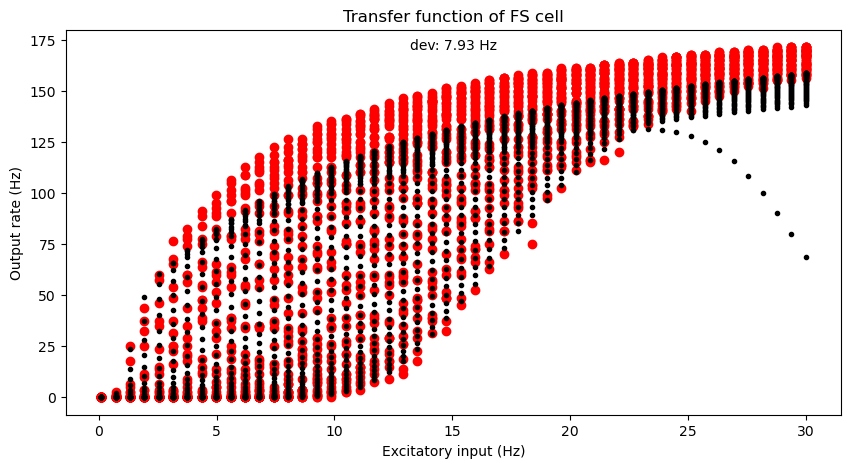

In [391]:
cell = 'FS'
pts = 50
save_name = 'trial'
# cell_sm = 'inh'
file = f'./data/ExpTF_{pts}x{pts}_{save_name}_{cell}.npy'

adapt_file= f"./data/{pts}x{pts}_{save_name}_{cell}_adapt.npy"
file_fit =f"./data/{pts}x{pts}_{save_name}_{cell}_fit.npy"
# file_fit ='FS-cell_CONFIG1_fit.npy'
param_file = f'./data/{pts}x{pts}_{save_name}_{cell}_params.npy'

P = np.load(file_fit)
plot_check_fit(file, param_file, adapt_file ,cell, P, w_prec=False)

(50, 50)


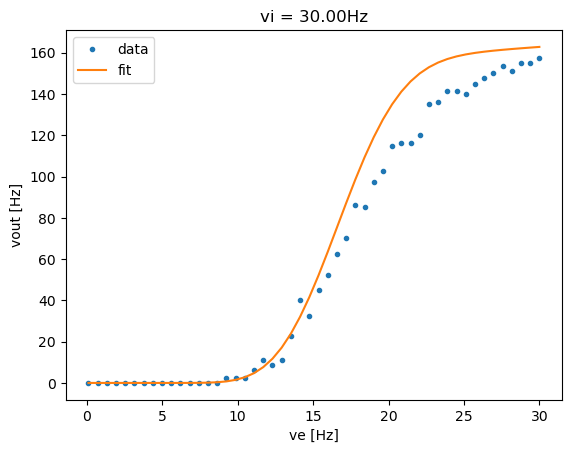

In [387]:
cell = 'FS'
pts = 50
save_name = 'trial'
# cell_sm = 'inh'
file = f'./data/ExpTF_{pts}x{pts}_{save_name}_{cell}.npy'

adapt_file= f"./data/{pts}x{pts}_{save_name}_{cell}_adapt.npy"
file_fit =f"./data/{pts}x{pts}_{save_name}_{cell}_fit.npy"
file_fit ='FS-cell_CONFIG1_fit.npy'
# file_fit ='RS-cell0_CONFIG1_fit.npy'
param_file = f'./data/{pts}x{pts}_{save_name}_{cell}_params.npy'

P = np.load(file_fit)
video_check_fit(file, param_file, adapt_file ,cell, P, w_prec=False)

In [221]:
file_rs ='RS-cell0_CONFIG1_fit_2.npy'

PRS = np.load(file_rs)

In [223]:
PRS.shape

(10,)

[-0.04827566 -0.00286298  0.00146366 -0.01987102  0.00334947  0.02838867
  0.03494976  0.00956849  0.01403622  0.02891829]
cell parameters in SI units


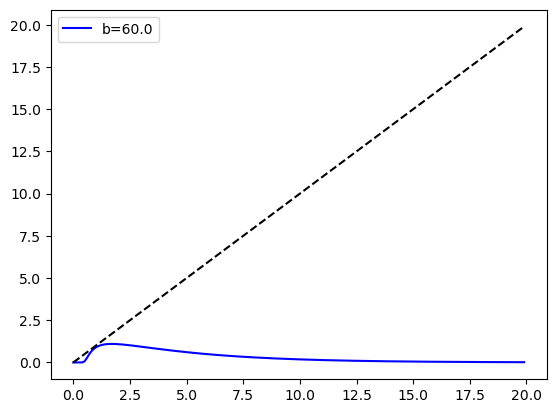

WARNING    c:\Users\maria\Documents\tvb\Paper_github\Tf_calc\theoretical_tools.py:333: RuntimeWarning:

invalid value encountered in sqrt

 [py.warnings]


2024-05-15 01:37:39,416 - WARNING - py.warnings - c:\Users\maria\Documents\tvb\Paper_github\Tf_calc\theoretical_tools.py:333: RuntimeWarning:

invalid value encountered in sqrt




RuntimeError: Failed to converge after 3000 iterations, value is [nan]

In [397]:
file_fs= 'FS-cell_CONFIG1_fit.npy'
file_fs= "./data/{0}x{1}_{2}_{3}_fit.npy".format(50,50, 'trial', 'FS' )
file_rs ='RS-cell0_CONFIG1_fit.npy'
pts=50
save_name = 'trial'
cell='RS'
file_rs =f"./data/{pts}x{pts}_{save_name}_{cell}_fit.npy"


plot_curve(NAME = 'FS-RS', file_rs =file_rs, file_fs= file_fs, 
               use_new=True, b_e=60e-12)

In [236]:
lol = np.load('./net_compar/FS-RS_0_mean_exc_amp_25.0.npy', allow_pickle=True)

In [238]:
lol = np.load('./net_compar/FS-RS_mean_exc_amp_25.0.npy', allow_pickle=True)

In [239]:
lol

array([6.24375, 25.0,
       {'V_m': -60, 'V_r': -65, 'Cm': 200, 'Gl': 10, 'tau_w': 500, 'V_th': -50, 'V_cut': -30, 'a_e': 0, 'b_e': 30, 'delta_e': 2, 'EL_e': -64, 'a_i': 0, 'b_i': 0, 'delta_i': 0.5, 'EL_i': -65, 'tau_e': 5, 'tau_i': 5, 'E_e': 0, 'E_i': -80, 'Q_i': 5.0, 'Q_e': 1.5, 'p_con': 0.05, 'gei': 0.2, 'Ntot': 10000}],
      dtype=object)

In [237]:
lol

array([12.710875000000001, 25.0,
       {'V_m': -60, 'V_r': -65, 'Cm': 200, 'Gl': 10, 'tau_w': 500, 'V_th': -50, 'V_cut': -30, 'a_e': 0, 'b_e': 0, 'delta_e': 2, 'EL_e': -64, 'a_i': 0, 'b_i': 0, 'delta_i': 0.5, 'EL_i': -65, 'tau_e': 5, 'tau_i': 5, 'E_e': 0, 'E_i': -80, 'Q_i': 5.0, 'Q_e': 1.5, 'p_con': 0.05, 'gei': 0.2, 'Ntot': 10000}],
      dtype=object)

In [398]:
CELLS = 'FS-RS'
path_net = "./net_compar/"
fr_both, inputs = load_network_mean(CELLS, path_net)


In [363]:
fr_both

array([[ 4.2475  ,  1.5105  ,  0.5     ],
       [12.7825  ,  3.174625,  2.5     ],
       [19.7845  ,  4.03725 ,  5.      ],
       [25.7755  ,  4.585   ,  7.5     ],
       [31.231   ,  4.941625, 10.      ],
       [41.3665  ,  5.51775 , 15.      ],
       [50.8095  ,  5.8655  , 20.      ],
       [59.98    ,  6.24375 , 25.      ]])

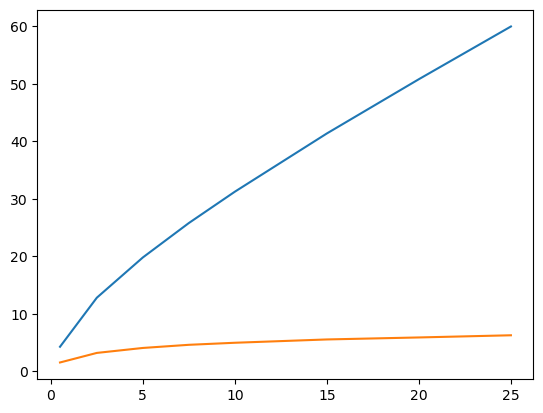

In [399]:
plt.plot(inputs, fr_both[:,:2]);

In [351]:
inputs

array([ 0.5,  2.5,  5. ,  7.5, 10. , 15. , 20. , 25. ])

In [401]:
PRS = np.load(file_rs)
PFS = np.load(file_fs)
PFS = np.load("FS-cell_CONFIG1_fit.npy")
PRS = np.load("RS-cell0_CONFIG1_fit.npy")

calculate_mf_difference(CELLS, fr_both, inputs, PRS, PFS)

cell parameters in SI units
Input =  0.5
starting
cell parameters in SI units
Input =  2.5
starting
cell parameters in SI units
Input =  5.0
starting
cell parameters in SI units
Input =  7.5
starting
cell parameters in SI units
Input =  10.0
starting
cell parameters in SI units
Input =  15.0
starting
cell parameters in SI units
Input =  20.0
starting
cell parameters in SI units
Input =  25.0
starting
Whole difference:  [[ 3.29408466  1.15703276  0.5       ]
 [10.90949266  2.6355135   2.5       ]
 [17.1523923   3.43422899  5.        ]
 [22.49397631  3.96736928  7.5       ]
 [27.35035265  4.33085892 10.        ]
 [36.36010156  4.94930332 15.        ]
 [44.72113433  5.35390504 20.        ]
 [52.8261387   5.79129829 25.        ]]
mean difference exc:  3.9524387624314867
mean difference inh:  26.88845914510574


15.42

In [ ]:
Whole difference:  [[ 2.77208715  0.97455897  0.5       ]
 [11.13788023  2.79628471  2.5       ]
 [17.46501333  3.63682139  5.        ]
 [22.84789874  4.18644133  7.5       ]
 [27.73203144  4.5561176  10.        ]
 [36.78448099  5.17190753 15.        ]
 [45.18691948  5.56314405 20.        ]
 [53.34042395  5.98178817 25.        ]]

In [19]:
def load_network_mean(CELLS, path_net):
        #load network
    fr_inh=[]
    fr_exc=[]
    for file in os.listdir(path_net):
        if file.startswith(CELLS):
            if "inh" in file:
                mean_fr, amp, _ = np.load(path_net+file, allow_pickle=True)
                fr_inh.append([mean_fr, amp])
            elif "exc" in file:
                mean_fr, amp, _ = np.load(path_net+file, allow_pickle=True)
                fr_exc.append([mean_fr, amp])
    fr_exc = np.array(sorted(fr_exc, key=lambda x: x[1]))
    fr_inh = np.array(sorted(fr_inh, key=lambda x: x[1]))
    fr_both = np.column_stack((fr_inh[:,0], fr_exc ))
    
    inputs = fr_both[:,-1]

    return fr_both, inputs

def calculate_mf_difference(CELLS, fr_both, inputs, PRS, PFS):
    mean_both =[]
    for AmpStim in inputs:
        mean_exc, mean_inh = run_MF(CELLS, AmpStim, PRS, PFS, Iext=0, TotTime=2)
        mean_both.append([mean_inh, mean_exc, AmpStim])

    dif_arr = np.abs(fr_both - np.array(mean_both))

    if dif_arr[:,-1].any() !=0:
        raise Exception("difference of inputs should be 0 but it is not")

    print("Whole difference: ", dif_arr)
    print("mean difference exc: ", np.mean(dif_arr[:,1]))
    print("mean difference inh: ", np.mean(dif_arr[:,0]))
    
    dif = np.mean(dif_arr[:,:2])

    return dif 

In [368]:
from Tf_calc.theoretical_tools import fit_with_MF

save_name = 'trial'
cell = 'FS'
cell_sm = 'inh'

file = f'./data/ExpTF_{cell_sm}_fr_50x50_{save_name}.npy'
param_file = f'./data/params_range_50x50_{save_name}.npy'
adapt_file= f"./data/ExpTF_RS_adapt_50x50_{save_name}.npy"

file = f'./data/ExpTF_{cell_sm}_50x50_{save_name}.npy'
param_file = f'./data/params_range_50x50_{save_name}.npy'
adapt_file= f"./data/ExpTF_Adapt_inh_50x50_trial.npy"

CELLS = 'FS-RS'
fit_with_MF(file, CELLS, param_file, adapt_file,max_iter = 30, dif = 5, range_exc=None, range_inh=None, window=15, loop_n=1, w_prec=True,  path_net= "./net_compar/")
    

FileNotFoundError: [Errno 2] No such file or directory: './data/ExpTF_inh_50x50_trial.npy'

In [28]:
file.split('.')[1]

'/data/ExpTF_exc_50x50_b_e_10'

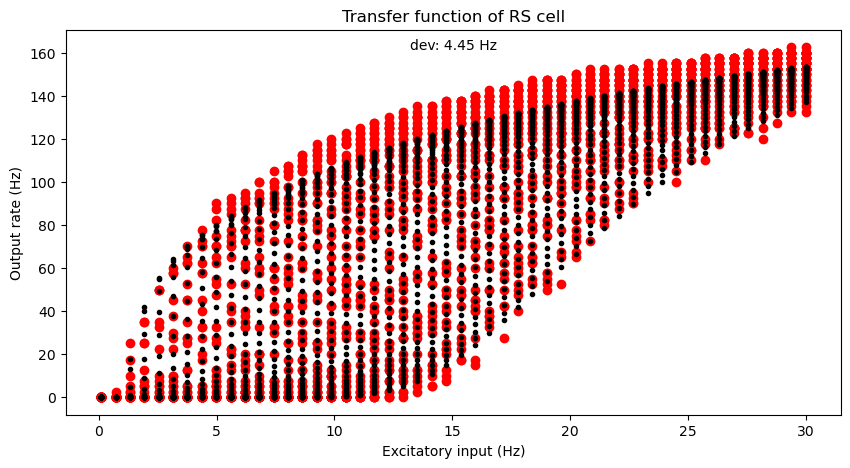

In [39]:
cell_type='FS'
file = './data/ExpTF_exc_50x50_b_e_10.npy'
file = './data/ExpTF_RS_fr_50x50_b_e_0.npy'

file_p = file.split('.npy')[0] + f'_{cell_type}__fit.npy'

param_file = './data/RS_params_range_50x50_b_e_10.npy'
param_file = './data/RS_params_range_50x50_b_e_0.npy'

adapt_file = './data/ExpTF_Adapt_50x50_b_e_10.npy'
adapt_file = './data/ExpTF_RS_adapt_50x50_b_e_0.npy'
P = np.load(file_p)

# P=np.load(f'./data/ExpTF_inh_50x50_trial_{cell_type}__fit.npy')
# P =np.load('RS-cell0_CONFIG1_fit_2.npy')
# P = np.load('FS-cell_CONFIG1_fit_2.npy')
plot_check_fit(file, param_file, adapt_file ,cell_type, P)

In [29]:
ko = np.load("./data/ExpTF_exc_50x50_b_e_10_RS__fit.npy")
lo = np.load('RS-cell0_CONFIG1_fit_2.npy')


In [30]:
ko

array([-0.05,  0.  ,  0.  , -0.01,  0.  ,  0.  ,  0.02,  0.  ,  0.01,
       -0.  ])

[-0.05  0.    0.   -0.01  0.    0.    0.02  0.    0.01 -0.  ]
cell parameters in SI units


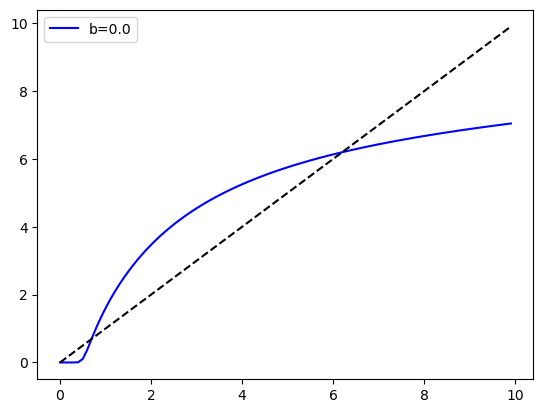

solution =  [6.2]


In [32]:
plot_curve( file_fs="./data/ExpTF_inh_50x50_trial_FS__fit.npy", file_rs=f"./data/ExpTF_exc_50x50_{save_name}_RS__fit.npy", use_new=True, b_e=0*1e-12)
# ko = [-0.05017034  0.00451531 -0.00794377 -0.00208418 -0.00054697  0.00341614
#  -0.01156433  0.00194753  0.00274079 -0.01066769]
# , file_rs="./data/ExpTF_exc_50x50_trial_RS__fit.npy"

cell parameters --NOT-- in SI units


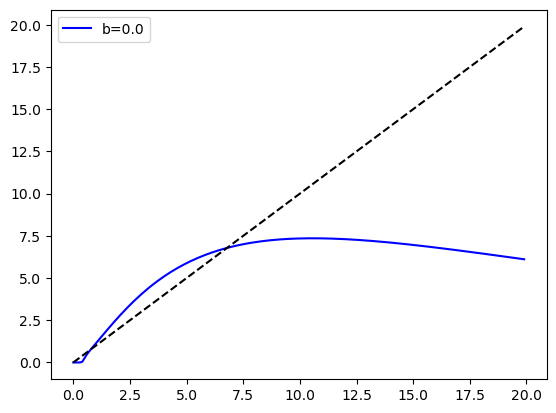

solution =  [6.78356851]


In [115]:
# calculate the fixed point

%run plot_curve.py 

In [28]:
from Tf_calc.theoretical_tools import *

In [161]:
P = np.load('./data/ExpTF_inh_50x50_trial_FS_fede_fit.npy')
adapt = np.load("./data/ExpTF_Adapt_inh_50x50_trial.npy")
file = './data/ExpTF_inh_50x50_trial.npy'
cell_type = 'FS'
param_file = './data/params_range_trial.npy'

feSim, fiSim, params = np.load(param_file,allow_pickle=True) 

In [38]:
feSim, fiSim, params = np.load(param_file,allow_pickle=True) 

In [39]:
params

{'V_m': -60,
 'V_r': -65,
 'Cm': 200,
 'Gl': 10,
 'tau_w': 500,
 'V_th': -50,
 'V_cut': -30,
 'a_e': 0,
 'b_e': 10,
 'delta_e': 2,
 'EL_e': -64,
 'a_i': 0,
 'b_i': 0,
 'delta_i': 0.50,
 'EL_i': -65,
 'tau_e': 5,
 'tau_i': 5,
 'E_e': 0,
 'E_i': -80,
 'Q_i': 5.00,
 'Q_e': 1.50,
 'p_con': 0.05,
 'gei': 0.20,
 'Ntot': 10000}

In [163]:
from scipy.ndimage import maximum_filter


mean error =  2.2277421948251015


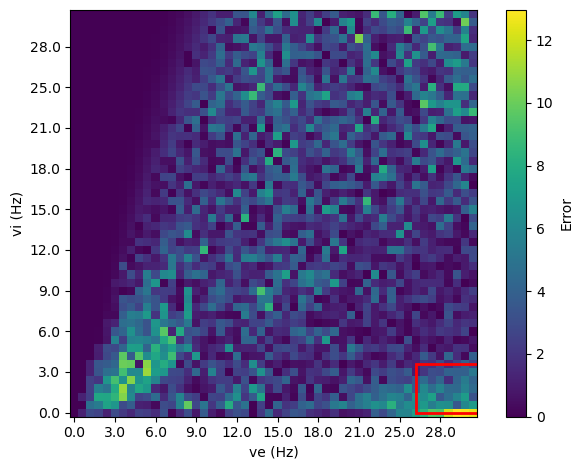

In [29]:
plot_example_adjust_range(file, param_file, adapt_file ,cell_type, P, window=5)

In [306]:
def refill_nans(array_original, array_nonan, bigindex):
    array_new = np.zeros_like(array_original.flatten())
    array_new[bigindex] = np.nan

    # array_new = np.empty_like(array_original.flatten())
    # array_new[:] = np.nan
    # array_new[bigindex] = 0

    c=0
    for i in range(len(array_new)):
        if np.isnan(array_new[i]):
            c+=1
            pass
        else:
            array_new[i] = array_nonan.flatten()[i-c]
    
    return array_new.reshape(array_original.shape)

In [327]:
def reshape_with_nans(vve, vvi, adapt, FF, params, cell_type):
    ve2, vi2, FF2, adapt2, bigindex = get_rid_of_nans(vve, vvi, adapt, FF, params, cell_type, return_index=True)

    vve_new = refill_nans(vve, ve2, bigindex)
    vvi_new = refill_nans(vvi, vi2, bigindex)
    adapt_new = refill_nans(adapt, adapt2, bigindex)
    FF_new = refill_nans(FF, FF2, bigindex)

    # vve_new = refill_nans(vve, vve, bigindex)
    # vvi_new = refill_nans(vvi, vvi, bigindex)
    # adapt_new = refill_nans(adapt, adapt, bigindex)
    # FF_new = refill_nans(FF, FF, bigindex)

    return vve_new, vvi_new, adapt_new, FF_new


In [329]:
vve_new, vvi_new, adapt_new, FF_new = reshape_with_nans(vve, vvi, adapt, FF, params, cell_type)

this many nans: 405


(2095,)


Text(0.5, 0.95, 'dev: nan Hz')

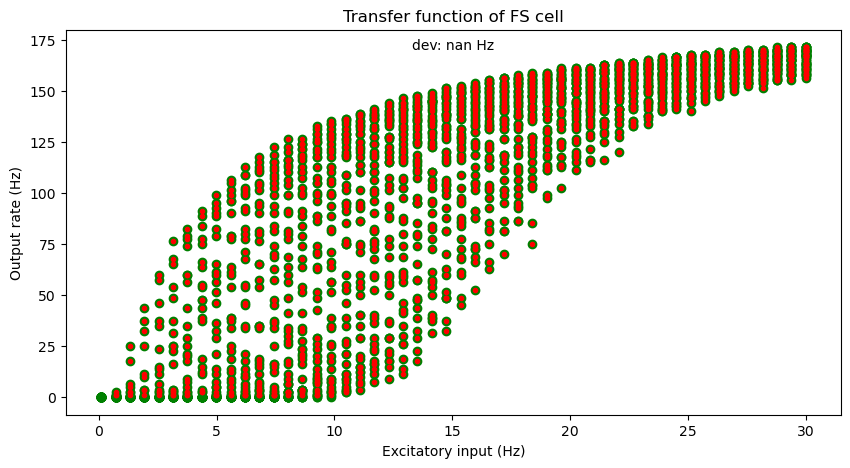

In [280]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Transfer function of FS cell')
ax.set_ylabel('Output rate (Hz)')
ax.set_xlabel('Excitatory input (Hz)')
    
inp_exc = feSim
vve, vvi = np.meshgrid(feSim, fiSim)
out_rate = np.load(file)

ve2, vi2, FF2, adapt2 = get_rid_of_nans(vve, vvi, adapt, FF, params, cell_type)

mu_V, sig_V, tau_V = mu_sig_tau_func(vve_new, vvi_new, adapt_new,params,cell_type)
g_L = 10 * 1e-9   # 30.0  /1.3
C_m = 200 * 1e-12  # 281.0 /1.1
tauN_V = tau_V * g_L / C_m

fit_rate = output_rate(P,mu_V, sig_V, tau_V, tauN_V)
# ax.plot(vi, fit_rate, 'k.', label='fit');
ax.plot(ve, FF, 'go', label='data');
ax.plot(ve, FF_new, 'r.', label='data');

mean_error = np.mean(np.sqrt((FF_new - fit_rate)**2))

ax.text(0.5, 0.95, f'dev: {mean_error:.2f} Hz', transform=ax.transAxes, ha='center')

In [410]:
P = np.load('./data/ExpTF_inh_50x50_trial_FS_fede_fit.npy')
adapt = np.load("./data/ExpTF_Adapt_inh_50x50_trial.npy")
adapt_file = "./data/ExpTF_Adapt_inh_50x50_trial.npy"
file = './data/ExpTF_inh_50x50_trial.npy'
cell_type = 'FS'
param_file = './data/params_range_trial.npy'


In [107]:
des_start = 0
des_end = 30
start = np.argmin(np.abs(vi - des_start))
end = np.argmin(np.abs(vi - des_end))
rid = range(start,end)


des_start = 15
des_end = 30
start = np.argmin(np.abs(ve - des_start))
end = np.argmin(np.abs(ve - des_end))
red = range(start, end)

In [49]:
desired_value = 10
closest_index = np.argmin(np.abs(vi - desired_value))
closest_index

16

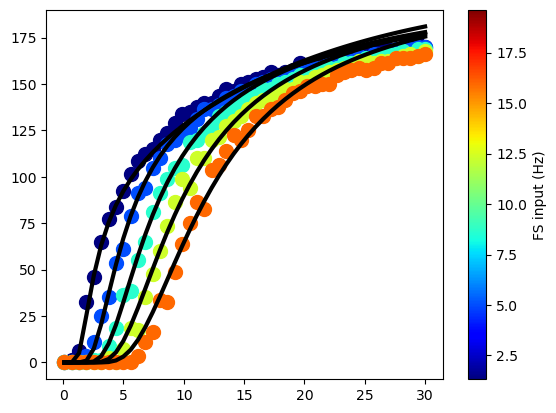

In [422]:
fig, ax = plt.subplots()
colormap = cm.jet
fs=[0,20,40,55,75,90]
index = 2
n_lines = 5
increment = 6

normalize = mcolors.Normalize(vmin=vi[index], vmax=vi[index + n_lines*increment])


for i in range(n_lines):
    # print(vi[index])
    ax.scatter(vve[index], out_rate.T[index], color=colormap(normalize(vi[index])), s=100)
    ax.plot(vve[index].squeeze(), fit_rate.T[index].squeeze(), 'k',  linewidth=3.0, label='fit')

    index+=increment
# ax.set_ylim(0.,50)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(vi)
plt.colorbar(scalarmappaple, label='FS input (Hz)')
plt.show()

NameError: name 'vvi' is not defined

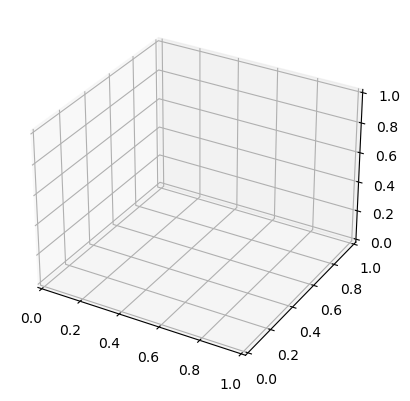

In [288]:
# Create a new figure
fig = plt.figure()

# Create axes for the 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot the data
# ax.plot3D(vvi.flatten(), vve.flatten(), FS.flatten(), 'ob', markersize=1, label='FS')
ax.plot3D(vvi.flatten(), vve.flatten(), out_rate.flatten(), 'or', markersize=1, label='data')
ax.plot3D(vvi.flatten(), vve.flatten(), fit_rate.flatten(), 'ob', markersize=1, label='fit')

# Set labels for the axes
ax.set_xlabel('vi')
ax.set_ylabel('ve')
ax.set_zlabel('vout')

ax.set_title("NO RANGE RS")

# Add a legend
ax.legend()

# Display the plot
plt.show()

In [46]:
plot_muv(vve, vvi, adapt,)

TypeError: mu_sig_tau_func() missing 2 required positional arguments: 'params' and 'cell_type'

In [35]:
vi = fiSim

In [44]:
vve,vvi=np.meshgrid(feSim, fiSim)
adapt= np.load(adapt_file)
out_rate=np.load(file).T

In [45]:
plot_veff(vve, vvi, adapt, out_rate)

TypeError: mu_sig_tau_func() missing 2 required positional arguments: 'params' and 'cell_type'

In [45]:
out_rate.shape

(50, 50)

In [13]:
adapt_fs = np.zeros_like(adapt)
adapt_fs.shape

(50, 50)

In [14]:
np.save("./data/ExpTF_Adapt_inh_50x50_trial.npy", adapt_fs)

In [157]:
ve, vi, params = np.load(param_file,allow_pickle=True)
FF= np.load(file)
PP = np.load('./data/ExpTF_inh_50x50_trial_fit.npy')

muV, sV, Tv, TvN = MPF(vve, vvi, FF, params, cell_type)


In [81]:
%matplotlib inline

In [10]:
ve = feSim
vi= fiSim

(50, 50)


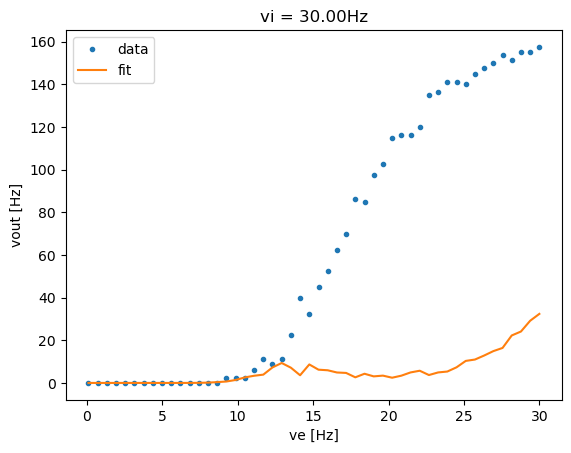

In [271]:
video_check_fit(file, param_file, adapt_file ,cell, P)

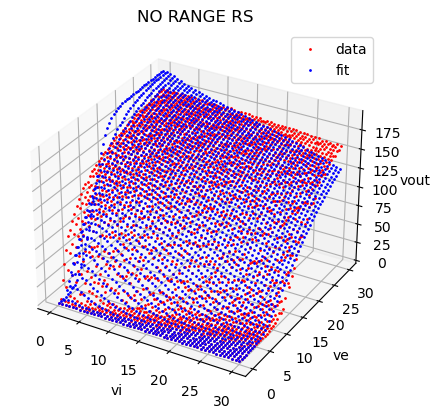

In [67]:
# Create a new figure
fig = plt.figure()

# Create axes for the 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot the data
# ax.plot3D(vvi.flatten(), vve.flatten(), FS.flatten(), 'ob', markersize=1, label='FS')
ax.plot3D(vvi.flatten(), vve.flatten(), FF.flatten(), 'or', markersize=1, label='data')
ax.plot3D(vvi.flatten(), vve.flatten(), TF(PP, muV, sV, Tv, TvN).flatten(), 'ob', markersize=1, label='fit')

# Set labels for the axes
ax.set_xlabel('vi')
ax.set_ylabel('ve')
ax.set_zlabel('vout')

ax.set_title("NO RANGE RS")

# Add a legend
ax.legend()

# Display the plot
plt.show()

<a id="fit-of-the-transfer-function"></a>
### Fit of the Transfer Function (to do)

<a id="mean-field-model"></a>
### Mean Field Model

In [62]:
from Tf_calc.cell_library import get_neuron_params_double_cell

params = get_neuron_params_double_cell('FS-RS')

params

{'V_m': -60,
 'a_e': 0,
 'a_i': 0,
 'V_r': -65,
 'tau_e': 5,
 'tau_i': 5,
 'b_e': 30,
 'b_i': 0,
 'delta_e': 2,
 'delta_i': 0.50,
 'El_e': -64,
 'El_i': -65,
 'V_th': -50,
 'E_e': 0,
 'E_i': -80,
 'Cm': 200,
 'Gl': 10,
 'tau_w': 500,
 'p_con': 0.05,
 'gei': 0.20,
 'Ntot': 10000,
 'Q_i': 5.00,
 'Q_e': 1.50}

In [32]:
%run MF_script_with_OS.py --help

usage: MF_script_with_OS.py [-h] [--b_e B_E] [--iext IEXT] [--tau_e TAU_E]
                            [--tau_i TAU_I] [--time TIME]

optional arguments:
  -h, --help     show this help message and exit
  --b_e B_E      adaptation - in pA
  --iext IEXT    external input - in Hz
  --tau_e TAU_E  excitatory synaptic decay - in ms
  --tau_i TAU_I  inhibitory synaptic decay - in ms
  --time TIME    Total Time of simulation - in s


In [ ]:
P[0] ok
P[1] ok 


In [34]:
PRS=np.load('RS-cell0_CONFIG1_fit.npy')
PFS=np.load('FS-cell_CONFIG1_fit.npy')

PRS

array([-0.05017034,  0.00451531, -0.00794377, -0.00208418,  0.001     ,
       -0.00054697,  0.00341614, -0.01156433,  0.00194753,  0.00274079,
       -0.01066769])

In [41]:
np.save('RS-cell0_CONFIG1_fit_2.npy', PR2)
np.save('FS-cell_CONFIG1_fit_2.npy', PF2)

In [40]:

PF2 = np.delete(PFS,4)
PF2

array([-0.05184978,  0.0061593 , -0.01403522,  0.00166511, -0.0020559 ,
        0.00318432, -0.03112775,  0.00656668,  0.00171829, -0.04516385])

In [38]:
PR2 = np.delete(PRS,4)
PR2

array([-0.05017034,  0.00451531, -0.00794377, -0.00208418, -0.00054697,
        0.00341614, -0.01156433,  0.00194753,  0.00274079, -0.01066769])

In [33]:
%run MF_script_with_OS.py

starting


IndexError: index 10 is out of bounds for axis 0 with size 10

starting
done


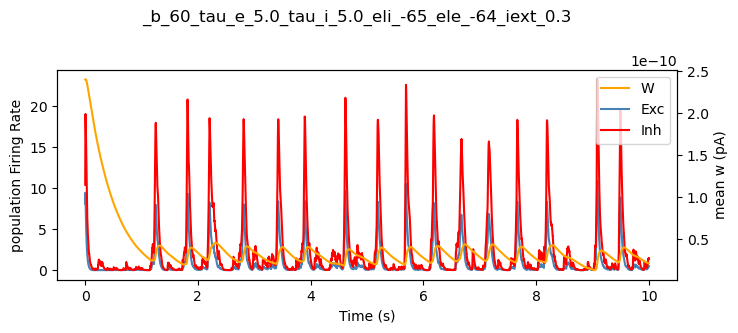

In [14]:
%run MF_script_with_OS.py --b_e=60

In [124]:
%run MF_script_with_OS.py --help

usage: MF_script_with_OS.py [-h] [--cells CELLS] [--b_e B_E] [--iext IEXT]
                            [--tau_e TAU_E] [--tau_i TAU_I]
                            [--use_new USE_NEW] [--time TIME]
                            [--fit_fs FIT_FS] [--fit_rs FIT_RS]
                            [--input INPUT]

options:
  -h, --help         show this help message and exit
  --cells CELLS      cell types of the populations
  --b_e B_E          adaptation - in pA
  --iext IEXT        external input - in Hz
  --tau_e TAU_E      excitatory synaptic decay - in ms
  --tau_i TAU_I      inhibitory synaptic decay - in ms
  --use_new USE_NEW  use input parameters - if False: will use the ones in
                     params file
  --time TIME        Total Time of simulation - in s
  --fit_fs FIT_FS    fit for fs
  --fit_rs FIT_RS    fit for rs
  --input INPUT      Stable input amplitude (Hz)


cell parameters in SI units
97800.0 100000
0.9774125272715113 -0.35003050354749093
starting
done


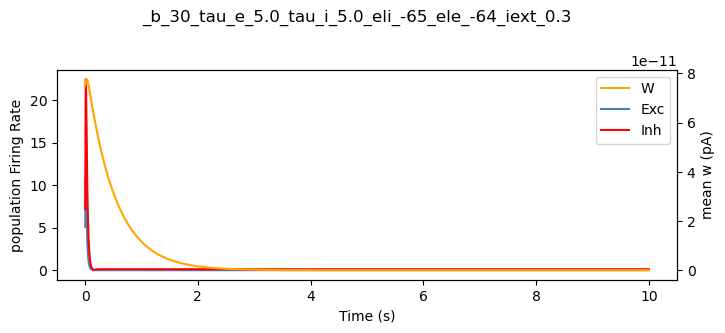

In [61]:
%run MF_script_with_OS.py --file_fs ./data/ExpTF_inh_50x50_trial_FS__fit.npy --file_rs ./data/ExpTF_exc_50x50_b_e_10_RS__fit.npy --input 5

1.0562832159870306 -0.4704784270573485 0.2971344034858762
starting
done


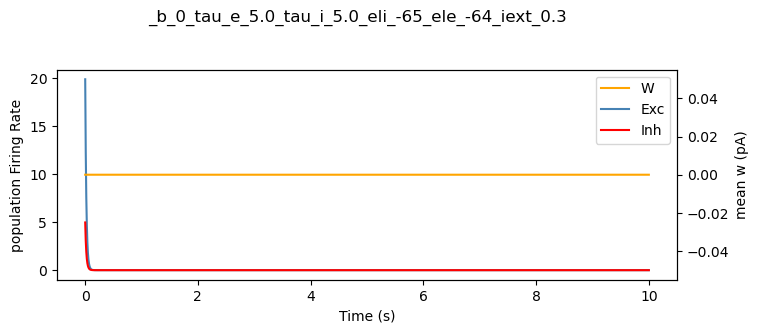

In [10]:
%run MF_script_with_OS.py --b_e=0 --iext=0.3 

<a id="whole-brain-model"></a>
### Whole Brain Model

#### Choose a connectome 

You have various options:

1. Get a default connectivity from TVB software

    - `parameters.parameter_connection_between_region['default'] = True`

2. Point to a zip folder (required files included in the zip folder: centres, tract_lengths, weights)

    - `parameters.parameter_connection_between_region['from_file'] = True`
    - `parameters.parameter_connection_between_region['path'] = path/to/zip/file`
    - `parameters.parameter_connection_between_region['conn_name'] = 'Connectivity.zip'` (add the actual zip name)

3. Point to an h5 file

    - `parameters.parameter_connection_between_region['path'] = path/to/h5/file CHECK`

4. Point to an unzipped folder that contains necessarily tract_lengths.txt and weights.txt (optional: region_labels, centres, cortical)

    - `parameters.parameter_connection_between_region['path'] = path/to/folder/containing/files`


In [4]:
# Choose the connectome

path_windows = r"C:\Users\maria\Downloads\tvb_data\tvb_data\connectivity"
path_linux = "/home/maria/Downloads/tvb_data/connectivity"
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_windows
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

##### Set up the parameters of the simulation

In [5]:
## Set the parameters of the simulation:
run_sim = 5000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [0]
tau_es = [5]

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

In [30]:
parameters.parameter_model

{'matteo': False,
 'order': 2,
 'g_L': 10.00,
 'E_L_e': -64.00,
 'E_L_i': -65.00,
 'C_m': 200.00,
 'b_e': 60.00,
 'a_e': 0.00,
 'b_i': 0.00,
 'a_i': 0.00,
 'tau_w_e': 500.00,
 'tau_w_i': 1.00,
 'E_e': 0.00,
 'E_i': -80.00,
 'Q_e': 1.50,
 'Q_i': 5.00,
 'tau_e': 5.00,
 'tau_i': 5.00,
 'N_tot': 10000,
 'p_connect_e': 0.05,
 'p_connect_i': 0.05,
 'g': 0.20,
 'T': 20.00,
 'P_e': [-0.05, 0.00, -0.01, -0.00, -0.00, 0.00, -0.01, 0.00, 0.00, -0.01],
 'P_i': [-0.05, 0.01, -0.01, 0.00, -0.00, 0.00, -0.03, 0.01, 0.00, -0.05],
 'external_input_ex_ex': 0.00,
 'external_input_ex_in': 0.00,
 'external_input_in_ex': 0.00,
 'external_input_in_in': 0.00,
 'tau_OU': 5.00,
 'weight_noise': 0.00,
 'K_ext_e': 400,
 'K_ext_i': 0,
 'initial_condition': {'E': [0.00, 0.00],
  'I': [0.00, 0.00],
  'C_ee': [0.00, 0.00],
  'C_ei': [0.00, 0.00],
  'C_ii': [0.00, 0.00],
  'W_e': [100.00, 100.00],
  'W_i': [0.00, 0.00],
  'noise': [0.00, 0.00]}}

In [23]:
dir(parameters)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'parameter_connection_between_region',
 'parameter_coupling',
 'parameter_integrator',
 'parameter_model',
 'parameter_monitor',
 'parameter_simulation',
 'parameter_stimulus']

In [49]:
parameters.parameter_simulation['path_result'] = './result/synch/'

In [36]:
parameters.parameter_model['external_input_ex_ex'] = 5e-3
parameters.parameter_model['external_input_in_ex'] = 5e-3

In [6]:
simulator = sim_init(parameters)
Nnodes = simulator.number_of_nodes

2024-05-15 14:29:17,084 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
Difference in key 'b_e':
   New dictionary value: 60.0
   Preexisting dictionary value: 100
Difference in key 'external_input_ex_ex':
   New dictionary value: 0.000315
   Preexisting dictionary value: 0.005
Difference in key 'external_input_in_ex':
   New dictionary value: 0.000315
   Preexisting dictionary value: 0.005
No differences in  model
No differences in  connectivity
No differences in  coupling
No differences in  integrator
No differences in  monitor
If there are no differences you can safely continue: press Y
Overwriting...


In [11]:
simulator.model

In [8]:
dir(simulator)

['TYPES_TO_DEEPCOPY',
 '__abstractmethods__',
 '__annotations__',
 '__call__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__doc_old__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_calculate_storage_requirement',
 '_census_memory_requirement',
 '_configure_history',
 '_configure_integrator_noise',
 '_configure_monitors',
 '_configure_stimuli',
 '_guesstimate_memory_requirement',
 '_guesstimate_runtime',
 '_loop_compute_node_coupling',
 '_loop_monitor_output',
 '_loop_update_history',
 '_loop_update_stimulus',
 '_memory_requirement_census',
 '_memory_requirement_guess',
 '_own_declarative_attrs',
 '_own_declarative_props',
 '_prepare_local_coupling',
 '_prep

#### Run the simulation


Here is an example of changing `tau_e` and `b_e`.

You can instead change `tau_i`, or other values (look at docs of `adjust_parameters`), by setting `tau_i = desired_value` as an argument in the functions:
- `adjust_parameters`
- `get_result`

and set `change_of = 'tau_i'` in:
- `access_results`
- `plot_tvb_results`



In [65]:
run_sim

2000.00

In [17]:
# Choose values of b_e and tau_e
bvals = [0, 100]
tau_es = [5, 5]
iext=10e-3
run_sim = 5000
cut_transient = 2000

In [68]:
cut_transient

200.00

In [28]:
from tvb.simulator.lab import *

In [34]:
(models.ZerlautAdaptationSecondOrder.TF)

<function tvb.simulator.models.zerlaut.ZerlautAdaptationFirstOrder.TF(self, fe, fi, fe_ext, fi_ext, W, P, E_L)>

In [30]:
dir(models)

['CoombesByrne',
 'CoombesByrne2D',
 'DecoBalancedExcInh',
 'DumontGutkin',
 'Enum',
 'Epileptor',
 'Epileptor2D',
 'EpileptorCodim3',
 'EpileptorCodim3SlowMod',
 'EpileptorRestingState',
 'GastSchmidtKnosche_SD',
 'GastSchmidtKnosche_SF',
 'Generic2dOscillator',
 'Hopfield',
 'JansenRit',
 'KIonEx',
 'Kuramoto',
 'LarterBreakspear',
 'Linear',
 'Model',
 'ModelsEnum',
 'MontbrioPazoRoxin',
 'ReducedSetFitzHughNagumo',
 'ReducedSetHindmarshRose',
 'ReducedWongWang',
 'ReducedWongWangExcInh',
 'SupHopf',
 'WilsonCowan',
 'ZerlautAdaptationFirstOrder',
 'ZerlautAdaptationSecondOrder',
 'ZetterbergJansen',
 '__builtins__',
 '__cached__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__file__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__loader__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__package__',
 '__path__',
 '__reduce__',
 '__reduce_

In [112]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,
                       cut_transient=cut_transient, run_sim=run_sim, Iext = iext)
    

Simulation Completed successfully


#### Load the Results

In [19]:
# Params to load 
bvals = [5, 60]
tau_es = [3.75, 5]

bvals = [0, 100]
tau_es = [5, 5]
iext=3e-3
#Which variables to load:
vars_int = ['E', 'I' ,'noise']

#Load
result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, vars_int = vars_int,Iext = iext)
    result.append(result_param)


Loading:  _b_e_0_tau_e_5_tau_i_5.0_Iext_0.003_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 1
Loading:  _b_e_100_tau_e_5_tau_i_5.0_Iext_0.003_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 1


In [20]:
# For explanation of the indexes of the result, uncomment the following:

access_results(for_explan, bvals, tau_es, change_of='tau_e')


Explaining the indices in result:
The result has a length equal to you different parameter combinations, i.e:
result[0]: for b_e = 0 and tau_e= 5
result[1]: for b_e = 100 and tau_e= 5

The result[i] is a list of arrays, every element of a list corresponds to a monitor:
Raw monitor : result[i][0]

Each monitor contains an array with the selected variables of interest, for all the time points and nodes
For example for Raw monitor:
For E : result[i][0][0]
For I : result[i][0][1]
For noise : result[i][0][2]

These arrays have shape: time_points x number_of_nodes: (30000, 76)


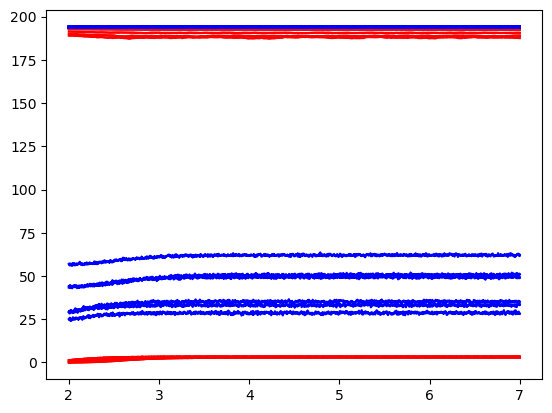

In [205]:
fr_exc_b0 =  result[0][0][0]
fr_inh_b0 =  result[0][0][1]
fr_exc_b100 =  result[1][0][0]
fr_inh_b100 =  result[1][0][1]
time = np.linspace(2,7, int(50e3))
nodes = np.arange(0,76)
plt.plot(time, fr_exc_b100[:,nodes], 'r');
plt.plot(time, fr_inh_b100[:,nodes], 'b');


In [132]:
simulator.connectivity.region_labels

array(['rA1', 'rA2', 'rAMYG', 'rCCA', 'rCCP', 'rCCR', 'rCCS', 'rFEF',
       'rG', 'rHC', 'rIA', 'rIP', 'rM1', 'rPCI', 'rPCIP', 'rPCM', 'rPCS',
       'rPFCCL', 'rPFCDL', 'rPFCDM', 'rPFCM', 'rPFCORB', 'rPFCPOL',
       'rPFCVL', 'rPHC', 'rPMCDL', 'rPMCM', 'rPMCVL', 'rS1', 'rS2',
       'rTCC', 'rTCI', 'rTCPOL', 'rTCS', 'rTCV', 'rV1', 'rV2', 'rCC',
       'lA1', 'lA2', 'lAMYG', 'lCCA', 'lCCP', 'lCCR', 'lCCS', 'lFEF',
       'lG', 'lHC', 'lIA', 'lIP', 'lM1', 'lPCI', 'lPCIP', 'lPCM', 'lPCS',
       'lPFCCL', 'lPFCDL', 'lPFCDM', 'lPFCM', 'lPFCORB', 'lPFCPOL',
       'lPFCVL', 'lPHC', 'lPMCDL', 'lPMCM', 'lPMCVL', 'lS1', 'lS2',
       'lTCC', 'lTCI', 'lTCPOL', 'lTCS', 'lTCV', 'lV1', 'lV2', 'lCC'],
      dtype='<U128')

In [149]:
len(fr_exc_b100.T)

76

In [152]:
for i in range(len(fr_inh_b100.T)):
    if np.mean(fr_inh_b100[:,i]) < 75:
        print(i)

2
5
9
19
35
37
40
43
47
57
73
75


In [169]:
nodes=[]
for i in range(len(fr_exc_b100.T)):
    if np.mean(fr_exc_b100[:,i]) < 25:
        print(i)
        nodes.append(i)

2
5
9
19
35
37
40
43
47
57
73
75


In [177]:
dic_means={}
for i in range(simulator.connectivity.weights.shape[0]):
    dic_means[i] = np.mean(simulator.connectivity.weights[i])

In [ ]:
dic_len={}
for i in range(simulator.connectivity.tract_lengths.shape[0]):
    dic_len[i] = np.mean(simulator.connectivity.tract_lengths[i])

In [167]:
dic_means.values()

dict_values([0.0077315235266651764, 0.009669779427168883, 0.0037308917122185524, 0.024325982461222816, 0.011549582298363548, 0.004622546017452885, 0.01623611149552219, 0.013357314650704777, 0.009317568985000527, 0.0004965243296921455, 0.019837827064520065, 0.016439239592294933, 0.010244103032704385, 0.013687172531235744, 0.01770639152072213, 0.012957065950225886, 0.019486954610790815, 0.019134074386962383, 0.019922665743229564, 0.0017962882165438374, 0.01543688581182288, 0.02353051090163562, 0.018606583095557672, 0.01863734857456654, 0.01377955281511883, 0.017239555565727996, 0.017209391905264285, 0.010453872859795085, 0.008944687611425773, 0.008120348508396316, 0.016170876180451776, 0.0080741846404392, 0.010876672829444387, 0.012116951691348458, 0.012793650137591376, 0.006161293995083665, 0.016440426646211512, 0.0, 0.007731519603042125, 0.00966977658193172, 0.0037308917122185524, 0.024325950749575692, 0.011549539939183428, 0.00462250685958915, 0.016236074638348762, 0.01335730502970416

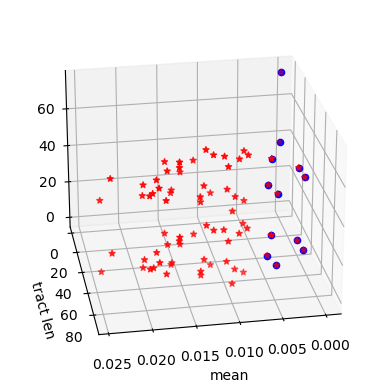

In [204]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter( dic_means.values(), dic_len.values(),dic_means.keys(), marker='*', color='red')
for nod in nodes:
    ax.scatter( dic_means[nod], dic_len[nod],nod, marker='o', color='blue')
ax.set_xlabel('mean')
ax.set_ylabel('tract len')
# ax.set_zlabel('node number')
ax.view_init(elev=25, azim=80)


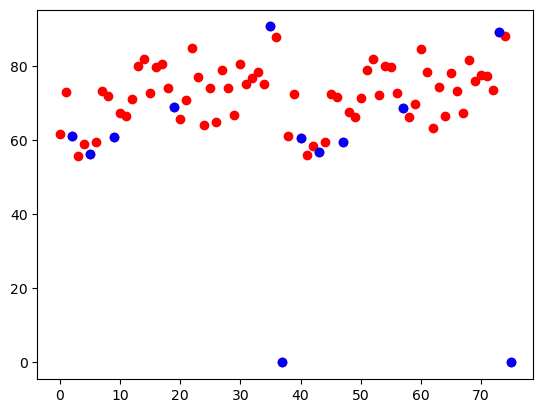

In [176]:
plt.plot(dic_len.keys(), dic_len.values(), 'ro')
for nod in nodes:
    plt.plot(nod, dic_len[nod], 'bo')

In [ ]:
fr_exc_b0 =  result[0][0][0]
fr_inh_b0 =  result[0][0][1]
fr_exc_b100 =  result[1][0][0]
fr_inh_b100 =  result[1][0][1]
time = np.linspace(2,7, int(50e3))
nodes = np.arange(0,76)
plt.plot(time, fr_exc_b0[:,nodes], 'r');
plt.plot(time, fr_inh_b0[:,nodes], 'b');
time = np.linspace(2,7, int(50e3))
nodes = np.arange(0,76,5)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, fr_exc_b100[:,nodes], 'r');
ax.plot(time, fr_inh_b100[:,nodes], 'b');

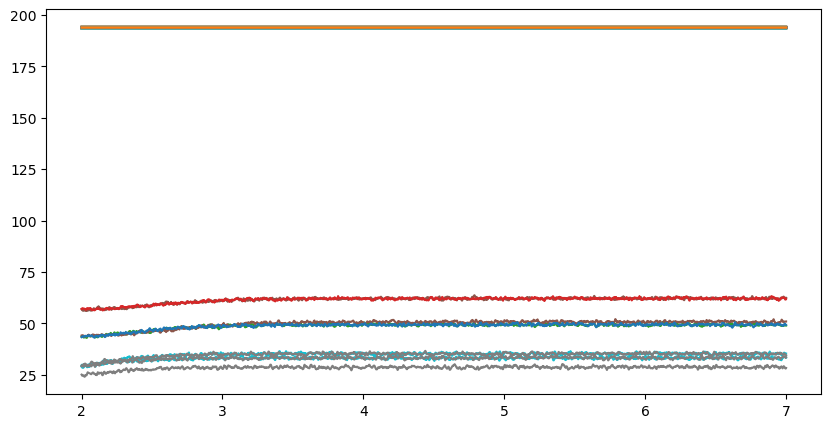

In [151]:
time = np.linspace(2,7, int(50e3))
nodes = np.arange(0,72,1)
fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(time, fr_exc_b100[:,nodes]);
ax.plot(time, fr_inh_b100[:,nodes]);
# plt.ylim(2,4)

#### Plot the Results

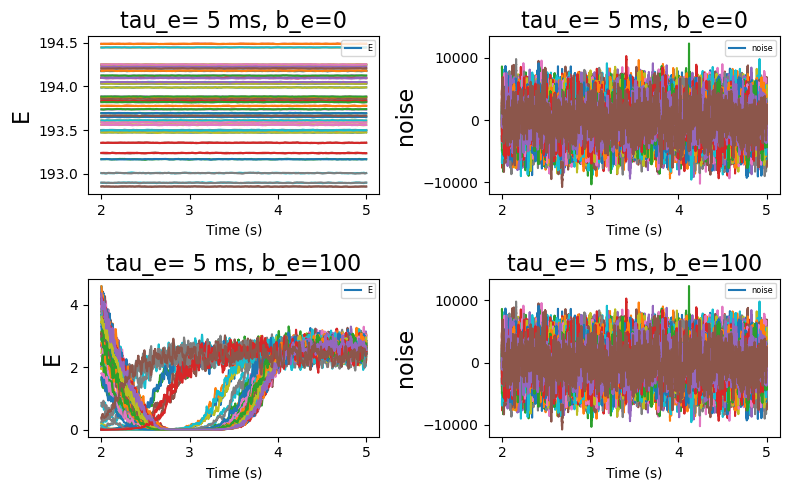

In [21]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Raw'

#which variables
var_select = ['E',  'noise']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[5, 3.75], [60,5]]
params = [[0, 5], [100,5]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim, Iext=iext)

<a id="pci"></a>
### Evoked Dynamics and PCI

#### Set up the parameters of the simulation

In [ ]:
## Set the parameters of the simulation:
run_sim = 4000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

These are additional parameters to adjust for the stimulation

In [ ]:
## Set the parameters of the stimulus 
stimval = 1e-3 #  stimulus strength in kHz - HERE NO ZERO ANYMORE
t_analysis  = 300. #in ms, for PCI analysis

# Loop over seeds to obtain multi5ple realizations of the model
Nseeds = 2 

# Onset time of the stimulus
stimtime_allseeds = np.random.rand(Nseeds)*(run_sim - cut_transient - 2*t_analysis) + t_analysis + cut_transient # shuffle in ms the start time of stimulus 
stimdur = 50 # ms, duration of the stimulus
stimtime_mean = 2500. # ms, time after simulation start (it will be shufled)
stim_region = 5

#### Run Simulation

In [ ]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

In [ ]:
# Run Simulation
for b_e, tau_e in zip(bvals, tau_es):
    for seed in range(Nseeds):
        run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,stimval = stimval, nseed=seed,
                       cut_transient=cut_transient, run_sim=run_sim)


#### Calculate PCI

In [ ]:
#Calculate PCI
params = [[5, 3.75, 2], [60, 5, 2]] 

for b_e, tau_e, n_seeds in params:
    calculate_PCI(parameters, n_seeds, run_sim, cut_transient, stimval=stimval, b_e=b_e, tau_e=tau_e, n_trials = 1)

#### Plot PCI #

Loading paper params:
For wake : b_e=5, tau=5.0
For nmda : b_e=30, tau=3.75
For gaba : b_e=30, tau=7.0
For sleep : b_e=120, tau=5.0
Seeds = 60, n_trials=5, stimvals=[1e-05, 0.0001, 0.001]
Creating PCI_all
Creating dataframe


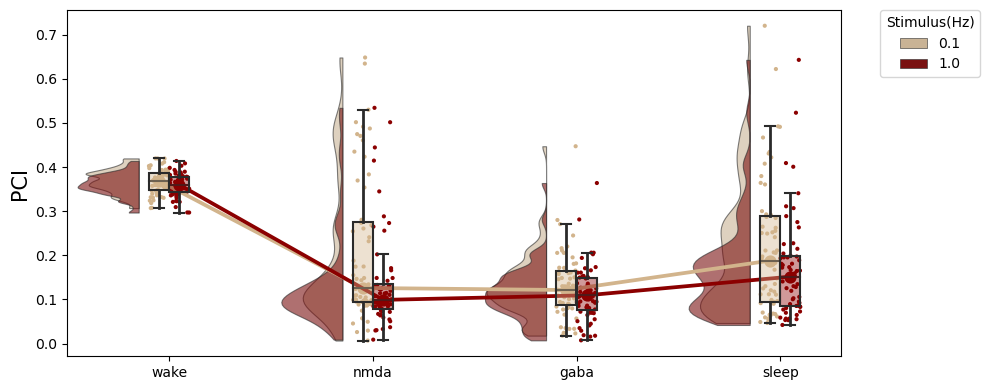

In [20]:
params = [[5, 3.75, 2], [60, 5, 2]] # b_e, tau, nseeds
conditions = ['nmda', 'sleep'] #conditions that the params describe - used for the x tick labels
stimvals = [1e-3] #stimvals to load
n_trials=1 #how many trials were used for the PCI

pick_stim = [1, 0.1] # stimulus strength to plot

#set this to True if you want to plot the already run stims, it will load params automatically
local_folder= True 


plot_raincloud_with_stats(parameters, params, n_trials=n_trials, stimvals=stimvals, pick_stim=pick_stim, conditions= conditions, local_folder=local_folder)

<a class="anchor" id="bold-and-fc"></a>
### Simulating BOLD signal and calculating FC-SC Correlation

#### Set up the parameters of the simulation

In [ ]:
# Do that to initialize the parameters
parameters.__init__()

In [27]:
simulator.connectivity

array(4.)

In [5]:
# Choose the connectome

path_windows = r"C:\Users\maria\Downloads\tvb_data\tvb_data\connectivity"
path_linux = "/home/maria/Downloads/tvb_data/connectivity"
parameters.parameter_connection_between_region['from_file'] = True
parameters.parameter_connection_between_region['path'] = path_linux
parameters.parameter_connection_between_region['conn_name'] = 'connectivity_76.zip'

For the BOLD monitor long simulations are needed, so set a long `run_sim`

In [6]:
## Set the parameters of the simulation:
run_sim = 100000 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

# List of values of adaptation strength and tau_e which will vary the brain state
bvals = [5]
tau_es = [3.75]

## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)
stimval = 0 #  stimulus strength

Set `parameter_monitor['Bold'] = True` 
- (if you want you can simulate another monitor)

In [7]:
#Set Bold Monitor
parameters.parameter_monitor['Bold'] = True
# parameters.parameter_monitor['parameter_Bold']['period'] = 2000 

#Deactivate Raw, and keep Temporal Average instead ( faster )
parameters.parameter_monitor['Raw'] = False
parameters.parameter_monitor['TemporalAverage'] = True
parameters.parameter_monitor['parameter_TemporalAverage']['variables_of_interest'] = [0,1]

In [8]:
# Choose values of b_e and tau_e
bvals = [5]
tau_es = [3.75]

#### Run Simulation

In [ ]:
# Run sim

#Set a subfolder where the results will be saved, otherwise they can be overwritten 
additional_path_folder='Bold/'

for b_e, tau_e in zip(bvals, tau_es):
    run_simulation_all(parameters, b_e = b_e, tau_e = tau_e,n_nodes=Nnodes,stimval = stimval, nseed=seed,
                cut_transient=cut_transient, run_sim=run_sim,additional_path_folder=additional_path_folder)


#### Load Results

In [11]:
# Params to load 
bvals = [5]
tau_es = [3.75]

#Which Variables to load
vars_int = ['E' ]

result= []
for i, (b_e, tau_e) in enumerate(zip(bvals, tau_es)):
    result_param, for_explan = get_result(parameters,cut_transient, run_sim, b_e = b_e, tau_e = tau_e, 
    vars_int = vars_int, additional_path_folder=additional_path_folder)
    result.append(result_param)


WARNING    /DATA/Maria/paper_pipeline/functions.py:526: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp = np.array(result[i])
 [py.warnings]


Loading:  _b_e_5_tau_e_3.75_tau_i_5.0_Iext_0.000315_El_e_-64.0_El_i_-65.0_nseed_10
monitors: 2
2024-04-04 17:03:56,582 - WARNING - py.warnings - /DATA/Maria/paper_pipeline/functions.py:526: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp = np.array(result[i])


Explaining the indices in result:
The result has a length equal to you different parameter combinations, i.e:
result[0]: for b_e = 5 and tau_e= 3.75

The result[i] is a list of arrays, every element of a list corresponds to a monitor:
TemporalAverage monitor : result[i][0]
Bold monitor : result[i][1]

Each monitor contains an array with the selected variables of interest, for all the time points and nodes
For example for TemporalAverage monitor:
For E : result[i][0][0]

These arrays have shape: time_points x 

In [76]:
# For explanation of the indexes of the result, uncomment the following:
access_results(for_explan, bvals, tau_es, change_of='tau_e')



Explaining the indices in result:
The result has a length equal to you different parameter combinations, i.e:
result[0]: for b_e = 0 and tau_e= 5
result[1]: for b_e = 100 and tau_e= 5

The result[i] is a list of arrays, every element of a list corresponds to a monitor:
Raw monitor : result[i][0]

Each monitor contains an array with the selected variables of interest, for all the time points and nodes
For example for Raw monitor:
For E : result[i][0][0]
For I : result[i][0][1]
For noise : result[i][0][2]

These arrays have shape: time_points x number_of_nodes: (50000, 76)


#### Plot Results


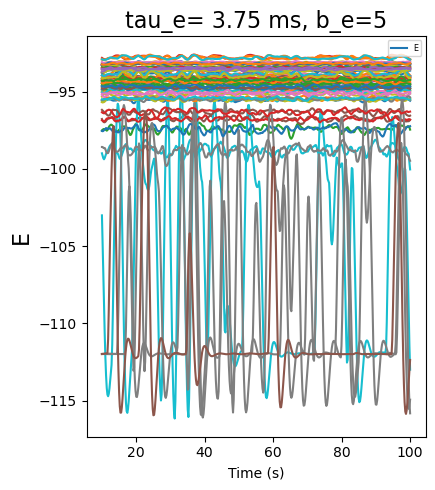

In [38]:
#Plot the results from TVB Simulations

#which monitor 
monitor = 'Bold'

#which variables to plot
var_select = ['E']

#which params (b_e, tau) - to be in the same order as the loading results (see explanations)
params = [[5, 3.75]]
plot_tvb_results(parameters,params, result, monitor, for_explan, var_select,cut_transient, run_sim, 
                 additional_path_folder=additional_path_folder, desired_time=10)

### Compute Corr FC and SC

450 76


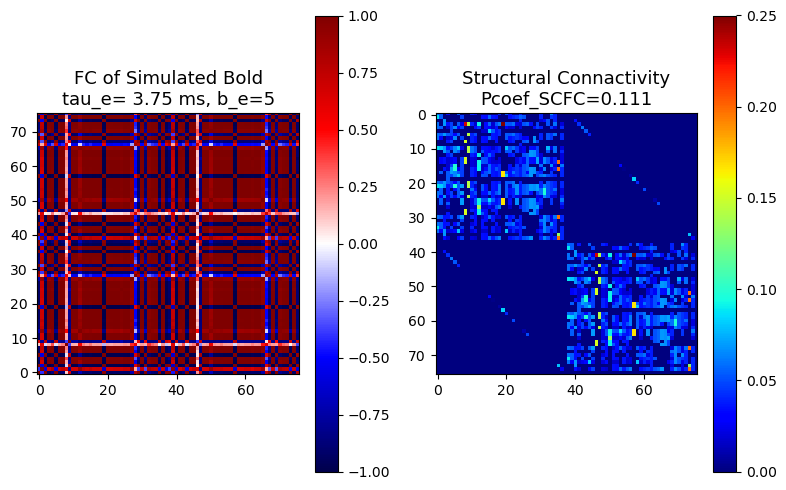

In [97]:
#Add the SC
SC=simulator.connectivity.weights

plot_FC_SC(parameters,params, result, for_explan, cut_transient, run_sim, SC, 
            additional_path_folder=additional_path_folder,desired_time=10)

<a class="anchor" id="dynamical-analysis"></a>
## Dynamical Analysis (to do)

#### Network Simulations and Survival Time

1. First run network simulations for different values of tau_e/tau_i and b_e
2. Calculate the survival time for each combination of tau/b_e

In [59]:
%run net_sims_dyn_analysis.py --help

usage: net_sims_dyn_analysis.py [-h] [--b_e_range B_E_RANGE]
                                [--tau_e_range TAU_E_RANGE]
                                [--tau_i_range TAU_I_RANGE] [--nseeds NSEEDS]
                                [--time TIME] [--save_path SAVE_PATH]
                                [--overwrite OVERWRITE]
                                [--surv_time_calc SURV_TIME_CALC]

optional arguments:
  -h, --help            show this help message and exit
  --b_e_range B_E_RANGE
                        b_e range of values (default: 0,30,1)
  --tau_e_range TAU_E_RANGE
                        tau_e range of values - if you iterate tau_i then set
                        tau_e_range=np.arange(5.,10.,step=500) (default:
                        5.,7.,10)
  --tau_i_range TAU_I_RANGE
                        tau_i range of values - if you iterate tau_e then set
                        tau_i_range=np.arange(5.,10.,step=500) (default:
                        3.,9.,0.1)
  --nseeds NSEEDS  

In [61]:
%run net_sims_dyn_analysis.py --b_e_range '0,22,2' --tau_i_range '5, 5.5, 0.2' --nseeds '0,4,2' --surv_time_calc True --save_path './trials/'

Done! Network simulations are saved in ./trials//network_sims/ 
survival time (tau_i_mean_array.npy) 
with the respective values of b_e (tau_i_heatmap_bvals.npy) and 
tau_i (tau_i_heatmap_taus.npy) in ./trials/


You can separately calculate the survival times if you have already run the network simulations:
- adjust the parameters accordingly

In [55]:
bvals = np.arange(0,22,step=2)
tauIv = np.arange(5.,5.5,step=0.2)
tauEv= np.arange(5.,9.,step=10)
Nseeds = np.arange(0,4,2)

if len(tauEv)==1 and len(tauIv)>1:
    tau_i_iter = True
    tau_values = tauIv
elif len(tauEv)>1 and len(tauIv)==1:
    tau_i_iter = False
    tau_values = tauEv

calculate_survival_time(bvals, tau_values, tau_i_iter, Nseeds, save_path ='./trials/')


Done! Saved in : ./trials/


#### Mean Field and b_critical Calculation


In [73]:
%run calculate_b_crit.py --help

usage: calculate_b_crit.py [-h] [--b_e_range B_E_RANGE]
                           [--tau_e_range TAU_E_RANGE]
                           [--tau_i_range TAU_I_RANGE] [--save_path SAVE_PATH]
                           [--overwrite OVERWRITE]

optional arguments:
  -h, --help            show this help message and exit
  --b_e_range B_E_RANGE
                        b_e range of values (default: [ 0 1 2 3 4 5 6 7 8 9 10
                        11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
                        29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
                        47 48 49 50 51 52 53 54 55 56 57 58 59])
  --tau_e_range TAU_E_RANGE
                        tau_e range of values - if you iterate tau_i then set
                        tau_e_range=np.arange(5.,10.,step=500) (default: [5.])
  --tau_i_range TAU_I_RANGE
                        tau_i range of values - if you iterate tau_e then set
                        tau_i_range=np.arange(5.,10.,step=500) (def

In [21]:
%run calculate_b_crit.py --tau_i_range '5,7,0.2' --overwrite=True --save_path='./trials/' 

5.0 5.0
crit b =  20
5.2 5.0
crit b =  18
5.4 5.0
crit b =  16
5.6000000000000005 5.0
crit b =  13
5.800000000000001 5.0
crit b =  11
6.000000000000001 5.0
crit b =  9
6.200000000000001 5.0
crit b =  7
6.400000000000001 5.0
crit b =  5
6.600000000000001 5.0
crit b =  3
6.800000000000002 5.0
crit b =  2


### Plot the heatmap

In [6]:
mean_array[:,10:].shape

(25, 50)

In [22]:
len(taus)

60

In [24]:
bthr

[48.00,
 46.00,
 44.00,
 43.00,
 41.00,
 40.00,
 38.00,
 37.00,
 35.00,
 34.00,
 33.00,
 31.00,
 30.00,
 29.00,
 27.00,
 26.00,
 25.00,
 24.00,
 23.00,
 21.00,
 20.00,
 19.00,
 18.00,
 17.00,
 16.00,
 15.00,
 13.00,
 12.00,
 11.00,
 10.00,
 9.00,
 8.00,
 7.00,
 6.00,
 5.00,
 4.00,
 3.00,
 2.00,
 2.00,
 1.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 1.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 0.00,
 1.00,
 0.00]

In [25]:
mean_array_2 = mean_array[:,10:]
taus, bthr, tau_v = taus[10:], bthr[10:], tau_v[10:]

In [29]:
plot_heatmap_survival(mean_array_2, taus, tau_v, bvals , bthr,load = load, save_im=False, z_max=200, precalc=True, line_color='gray', colorscale='jet')

In [56]:
mean_array,taus, bthr, tau_v, bvals = load_survival( load = 'tau_i', precalc=True)


In [ ]:
l

In [57]:
len(bvals)

25

In [58]:
len(bvals_2)

25

In [49]:
mean_array_2=mean_array[:25,:]
bthr_2 = bthr[:25]
bvals_2 = bvals[:25]

In [54]:
np.max(bthr_2)

11.00

In [55]:
plot_heatmap_survival(mean_array_2, taus, tau_v, bvals_2 , bthr,load = load, save_im=False, z_max=200, precalc=False, line_color='yellow')

In [59]:
#This is an example with few values of tau_i and b_e
load= 'tau_i'
mean_array,taus, bthr, tau_v, bvals = load_survival( load = load, precalc=True)
plot_heatmap_survival(mean_array, taus, tau_v, bvals , bthr,load = load, save_im=False, z_max=200, precalc=True, line_color='yellow')

Or you can load directly a pre-calculated array with the mean survival time (averaged over seeds) for each combination of tau/b_e : 

In [13]:
load= 'tau_e'
mean_array,taus, bthr, tau_v, bvals = load_survival( load = load, precalc=True)
plot_heatmap_survival(mean_array, taus, tau_v, bvals , bthr,load = load, precalc=True, save_im=False, z_max=200, line_color='black', colorscale="jet") 